# Emotion Detection Using Speech 


## Overview 
 There's a lot that the human voice can tell us beyond just understanding what someone is saying but also how they are feeling and what emotions they are displaying. It can sometimes be obvious that an individual is happy or sad just by the tonal qualities of their voice and how they speak. Computers can also detect these differences and qualities in tone over the different emotions but it is a very hard problem to solve due to the differences in the human voice across the globe. But there are so many benefits that analyzing human speech can bring and there are many different ways to go about this problem. This project will be my approach to dealing with human speech data and using that data to come up with a solution to an already existing problem. The goal is to achieve a high accuracy with the model and have it be able to adequately classify an emotion when given new data. 

# Business Summary 

 It Can sometimes be difficult for doctors and therapists to pickup on emotions just because of the complexity of humans in general but a lot of the time you can tell how an individual is feeling just by the tone of their voice, so I am purposing a system that records a session between a therapist and a patient and it can detect an emotion that the therapist might have missed . It Can create a clearer picture of what subjects bring up what emotions and can keep a log of these emotions and can help diagnose patients. This system could also be implemented in a smart watch application that could monitor the patient at all times and notify the user when they are expressing a certain emotion. For example it could notify someone with anger management issues that they are losing control of there emotions and it could help the user calm down. 


In [22]:
# Importing Necessary Libraries 

# Standard Python Operations 
import pandas as pd 
import numpy as np
import math
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Audio Extraction and Augmentation tools
from scipy import signal 
import librosa 
import librosa.display 
import IPython.display as ipd

# Machine Learning 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Neural Networks 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.random import set_seed
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Data Understanding 

Source: https://smartlaboratory.org/ravdess/

The RAVDESS (Ryerson Audio-Visual Database of Emotional Speech and Song) is a widely used dataset for emotion classification using recorded speech because of its high quality and consistent audio quality. The dataset contains 24 actors (12 female and 12 male) vocalizing 2 different lexically-matched statements in a neutral North American accent. Each statement is spoken in 8 emotion classes with each class performed in 2 intensities (normal and intense). Each audio file is in .wav format, mono (1 channel) and with a sampling rate of 48,000 Hz. The duration of each track is between 3 and 5 seconds. 


Academic paper citation from the creators of RAVDESS:  https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0196391

# Creating Metadata table


RAVDESS does not come with any sort of metadata table with information on the recordings but instead the filename themselves have all the information. Each filename has a 7 part numerical identifier (ex. 03-01-04-01-01-02-12.wav). The identifiers represent the following: 

    1.) Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
    2.) Vocal channel (01 = speech, 02 = song).
    3.) Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
    4.) Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the ‘neutral’ emotion.
    5.) Statement (01 = “Kids are talking by the door”, 02 = “Dogs are sitting by the door”).
    6.) Repetition (01 = 1st repetition, 02 = 2nd repetition).
    7.) Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So for example the file 03-01-04-01-01-02-12.wav contains the following metadata: 

    1.) Audio-only (03)
    2.) Speech (01)
    3.) Sad (04)
    4.) Normal Intensity (01)
    5.) "Kids are talking by the door" (01)
    6.) Second Repetition (02)
    7.) Actor-12 Male (12) 

In [23]:

# Setting string representing path for folder containing audio files
Ravdess = '/Users/stephen/Emotion_Detection-/data/RAVDESS/'

# Turn Path string into Path Object 
ravdess_directory_list = os.listdir(Ravdess)
ravdess_directory_list.sort

# Create empty lists to store audio paths and their labels associated with each file 
file_emotion = []
file_path = []
# Since each actor is in there own folder we must iterate through each folder 
for dir in ravdess_directory_list:
    # as their are 24 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        # splitting up file name to decode labels 
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,angry,/Users/stephen/Emotion_Detection-/data/RAVDESS...
1,fear,/Users/stephen/Emotion_Detection-/data/RAVDESS...
2,fear,/Users/stephen/Emotion_Detection-/data/RAVDESS...
3,angry,/Users/stephen/Emotion_Detection-/data/RAVDESS...
4,disgust,/Users/stephen/Emotion_Detection-/data/RAVDESS...


In [24]:
# Lets take a look at our target variables 
Ravdess_df['Emotions'].value_counts()

angry       192
fear        192
disgust     192
sad         192
surprise    192
happy       192
calm        192
neutral      96
Name: Emotions, dtype: int64

/Users/stephen/opt/anaconda3/envs/torch_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


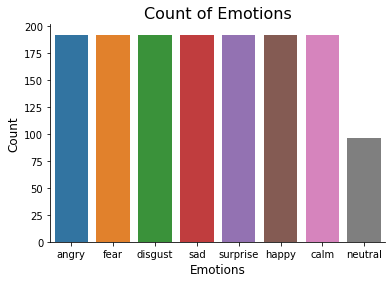

In [53]:
# Visuals of the data are always nice
plt.title('Count of Emotions', size=16)
sns.countplot(Ravdess_df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.savefig('/Users/stephen/Emotion_Detection-/images/emotion_count')
plt.show()


So we can see this is mostly a balanced dataset. The only issue is that there is almost half as many "Neutral" labels as there are any other label but I don't see this as an issue because it's not really an emotion but more the lack there of. 

# Audio Data Preparation 

There's not a lot we can do with just the raw audio so we'll use a Python library called Librosa to convert the audio files into an audio time series numpy array that we can do more with. First lets look at an audio file label as "angry" and we can map out the amplitude (or loudess/ volume) over time. This is a very basic waveform representation but its the starting point of a long process. 


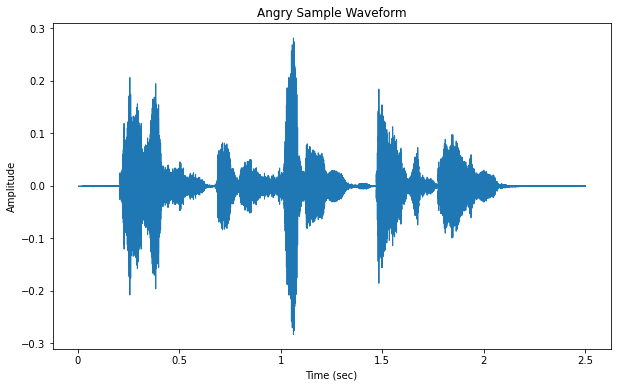

In [26]:
# declaring a variable that will locate an "angry" wav file to extract from 
angry_file_row = Ravdess_df.loc[Ravdess_df['Emotions'] == 'angry']
# grabbing just the index which is the actual path 
test_file_row = angry_file_row.iloc[0]
test_file_row

# librosa. load returns an audio time series numpyu array and an integer representing the sample rate.
y, sr = librosa.load(test_file_row['Path'], sr=16000, duration=2.5, offset=0.8) # 16000 is choosen because we only want frequencies up to 8000 hz so our sample rate shoudl be twice that according to Nyquist Theorem.  
# visualize waveform
fig, ax = plt.subplots(figsize=(10,6))
librosa.display.waveshow(y, sr=sr, ax=ax);
ax.set(title='Angry Sample Waveform', xlabel='Time (sec)', ylabel='Amplitude')
ax.label_outer();
plt.savefig('/Users/stephen/Emotion_Detection-/images/angry_waveform')

Still there is not much we can do this just a basic waveform like this so what we do is transform the waveform using the Fast Fourier Transform to convert the audio to the mel-spectrogram which shows not just the amplitude over time but the amplitude of the frequency content over time. The frequencies are scaled logarithmically to the mel scale, which approximates human hearing in regards to pitch. The amplitude or loudness of each frequency is also scaled logarithmically to decibels (dB) to approximate human hearing in regards to loudness. The reasoning is that humans perceive sound in relative changes not absolute changes.

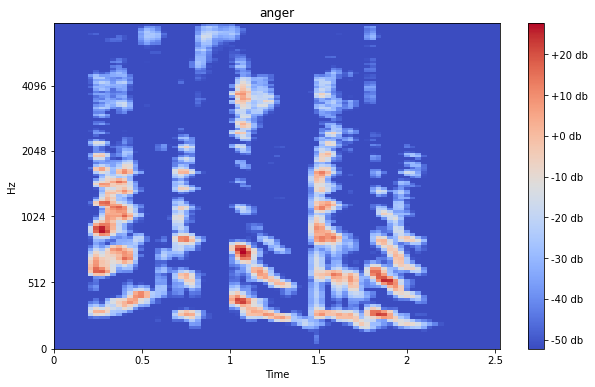

In [27]:
# mel spectrogram 
mel = librosa.feature.melspectrogram(y)
mel_db = librosa.amplitude_to_db(mel)
fig, ax = plt.subplots(figsize=(10, 6))

ang = librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel', ax=ax)
ax.set(title="anger")
ax.label_outer()
fig.colorbar(ang, ax=ax, format="%+2.f db");
plt.savefig('/Users/stephen/Emotion_Detection-/images/angry_spec')

# Data Augmentation 
Creating synthetic data in speech recognition models is important because it can be used to simulate the complexity and variance of the human voice. Time and pitch shifting can imitate fluctuation in the human voice. Adding noise can simulate background noise and can help with taking in new audio data that isn't recorded in the best conditions. |


## Audio Data Augmentation Functions 
here i will define some custom functions that'll be used in this process  

In [28]:
def noise(data, SNR=10):   
    """
    Adds Additive White Gausian Noise to signal 
    https://medium.com/analytics-vidhya/adding-noise-to-audio-clips-5d8cee24ccb

    the higher the SNR the lower the noise amplitude is. 
    finds RMS value of signal 
    Finds RMS value of noise 
    Uses population formula for standard deviation

    Args:
        data (np.darray): audio time series 
        SNR (int, optional): signal to noise ratio. Defaults to 10.

    Returns:
        (np.darray) : [Return original signal plus random noise]
    """
    RMS_s = math.sqrt(np.mean(data**2))
    RMS_n = math.sqrt(RMS_s**2/(pow(10,SNR/10)))
    STD_n = RMS_n 
    noise = np.random.normal(0, STD_n, data.shape[0])
    new_data = data + noise
    return new_data

# Time Strectching 
def stretch(data, rate=0.90):
    """
    Stretches audio data using librosa 
    librosa documentation: https://librosa.org/doc/main/generated/librosa.effects.time_stretch.html

    Args:
        data (np.ndarray): audio time series
        rate (float, optional): Stretch factor. If rate > 1, then the signal is sped up. If rate < 1,
                                         then the signal is slowed down.. Defaults to 0.90.

    Returns:
        (np.ndarray): audio time series stretched by the specified rate
    """
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    """
    Randomly shift timing of audio data 

    Args:
        data (np.ndarray): audio time series

    Returns:
        (np.ndarray): audio time series randomly shifted in time
    """
    shift_range = int(np.random.uniform(low=-1, high = 1)*1000)
    return np.roll(data, shift_range)

# Pre Emphasis 
def pre_emphasis(data, coef=1):
    """
    Adds Pre-Emphasis to audio signal 
    info on Pre-Emphasis in speech recognition https://wiki.aalto.fi/display/ITSP/Pre-emphasis
    librosa Pre-Emphasis documentation https://librosa.org/doc/main/generated/librosa.effects.preemphasis.html

    Args:
        data (np.ndarray): audio time series
        coef (int, optional): Pre-emphasis coefficient.. Defaults to 1.

    Returns:
        (np.ndarray): pre-emphasized signal
    """
    return librosa.effects.preemphasis(data, coef=1)

def pitch(data, sr=16000, n_steps=3):
    """
    Apply a pitch shift to an audio time series.
    Librosa pitch shift documentation http://librosa.org/doc/main/generated/librosa.effects.pitch_shift.html
    
    Args:
        data (np.ndarray): audio time series
        sr (int, optional): sample rate. Defaults to 16000.
        n_steps (int, optional): Shift by n_steps semitones. Defaults to 3.

    Returns:
        (np.ndarray): The pitch-shifted audio time-series
    """
    return librosa.effects.pitch_shift(data, sr, n_steps=1, bins_per_octave=24)

# Visualizing Data Augmentation 
Lets plot the original test audio signal next to a plot of the signal after it goes thru data augmentation 

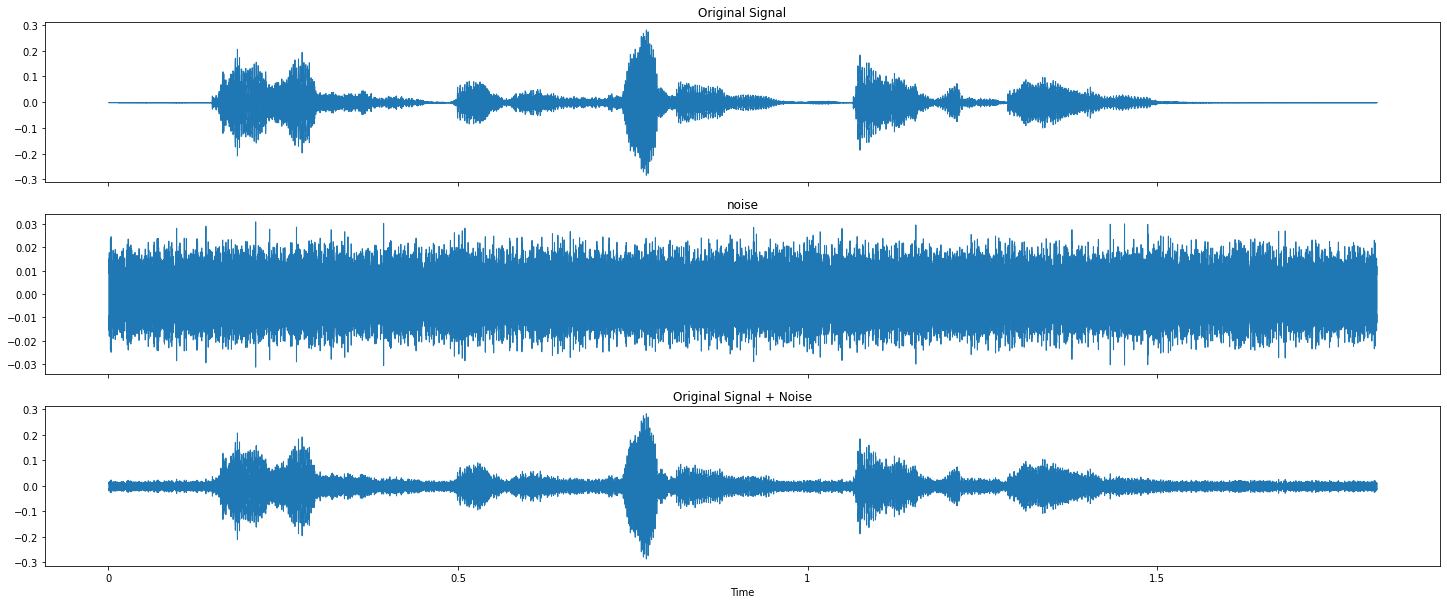

In [29]:
# Plotting the original "angry" audio test waveform, isolated noise generated using the original signals RMS, and the combined signals 

# create variables for easy use 
signal_with_noise = noise(y)
iso_noise = np.array(signal_with_noise - y)

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(25, 10))
ax = ax.ravel()
# original signal 
librosa.display.waveshow(y, ax=ax[0])
ax[0].set(title='Original Signal')
ax[0].label_outer()
# Isolated Noise 
librosa.display.waveshow(iso_noise, ax=ax[1])
ax[1].set(title='noise')
ax[1].label_outer()
# Summation of the two signals 
librosa.display.waveshow(signal_with_noise, ax=ax[2])
ax[2].set(title='Original Signal + Noise')
ax[2].label_outer()

# Time stretching 
We'll be creating synthetic data that is slowed down by 10% 

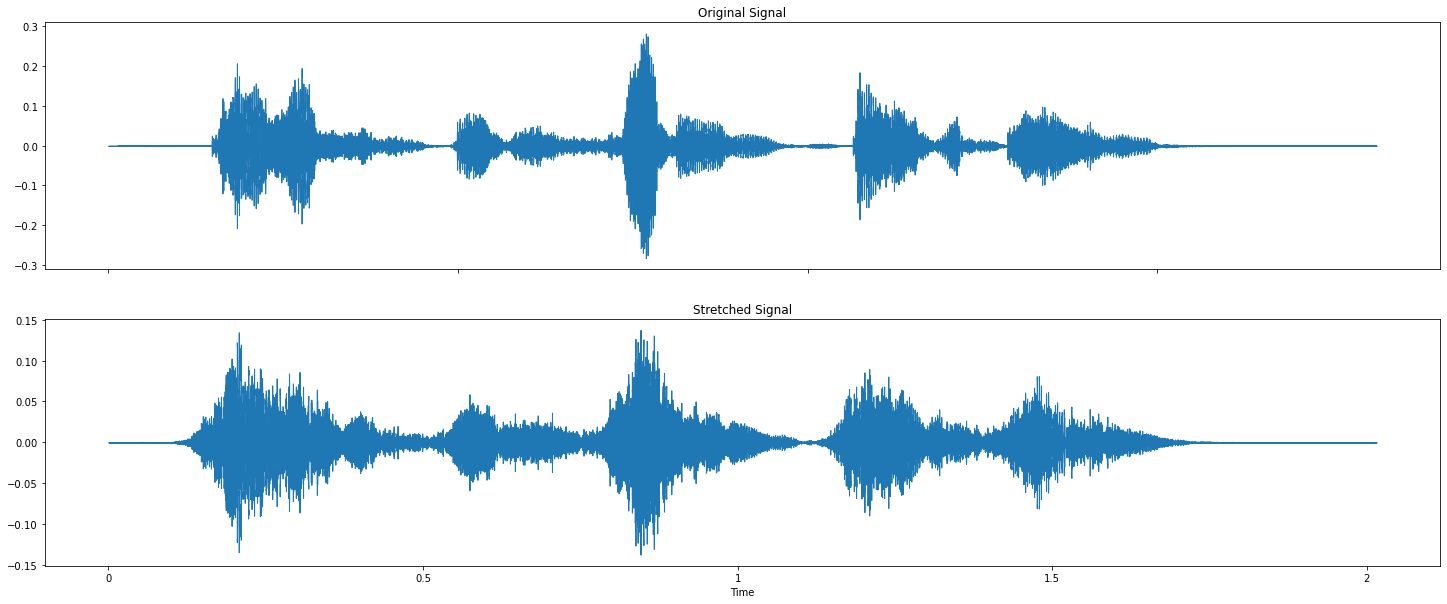

In [30]:
# Plotting orginal signal next to same signal slowed down by 10% 

# create variables for easy use 
slowed_down = stretch(y)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(25, 10))
ax = ax.ravel()
# original signal 
librosa.display.waveshow(y, ax=ax[0])
ax[0].set(title='Original Signal')
ax[0].label_outer()
# Stretched 
librosa.display.waveshow(slowed_down, ax=ax[1])
ax[1].set(title='Stretched Signal')
ax[1].label_outer()
plt.savefig('/Users/stephen/Emotion_Detection-/images/noise')


# Shifting 
randomly shiftss the position of the waveform. 

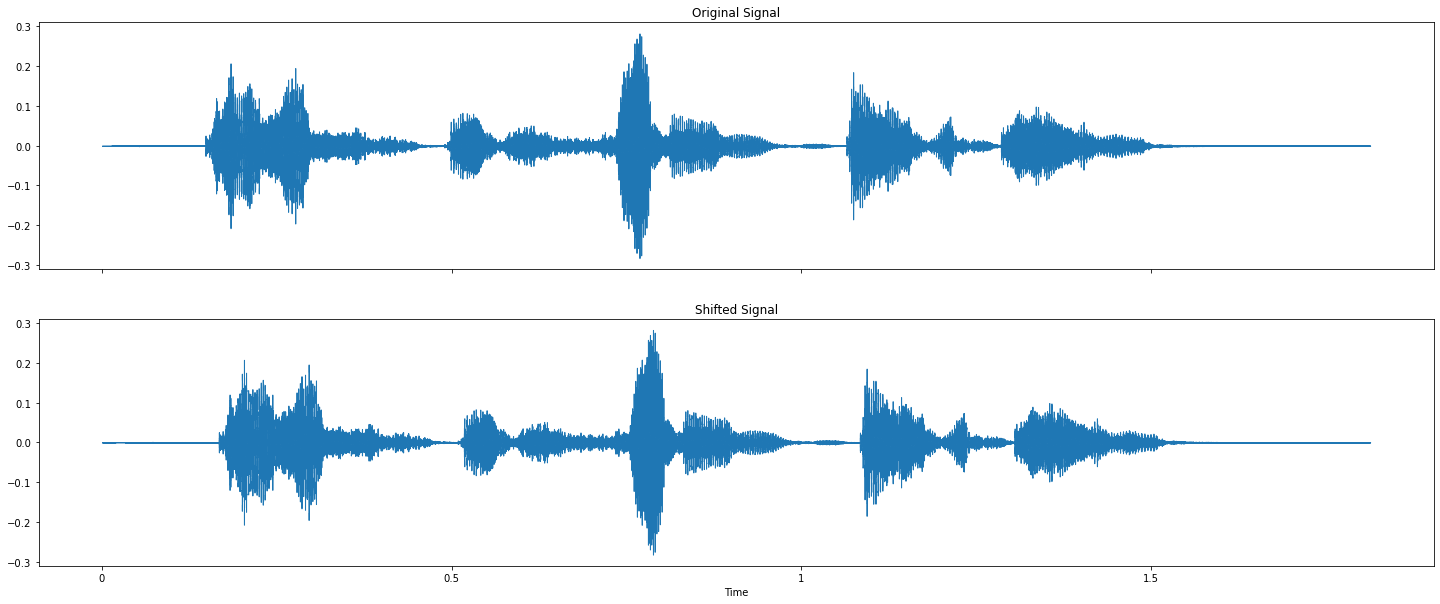

In [31]:
# Plotting orginal signal next to same signal slowed down by 10% 

# create variables for easy use 
shifted = shift(y)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(25, 10))
ax = ax.ravel()
# original signal 
librosa.display.waveshow(y, ax=ax[0])
ax[0].set(title='Original Signal')
ax[0].label_outer()
# shifted 
librosa.display.waveshow(shifted, ax=ax[1])
ax[1].set(title='Shifted Signal')
ax[1].label_outer()
plt.savefig('/Users/stephen/Emotion_Detection-/images/Shifted')

# Pitch shifting 
Creating synthetic data pitched down 2 semitones

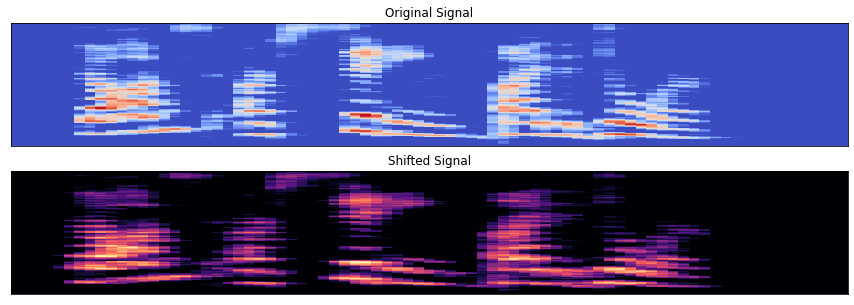

In [32]:
pitched = pitch(y)
pitched_mel = librosa.feature.melspectrogram(pitched)
pitched_db = librosa.amplitude_to_db(pitched_mel)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 5))
ax = ax.ravel()
# original signal 
librosa.display.specshow(mel_db, ax=ax[0])
ax[0].set(title='Original Signal')
ax[0].label_outer()
# Pitched down by 3 semitones 
librosa.display.specshow(pitched_db, ax=ax[1])
ax[1].set(title='Shifted Signal')
ax[1].label_outer()
plt.savefig('/Users/stephen/Emotion_Detection-/images/pitched')

Pre Emphasis 

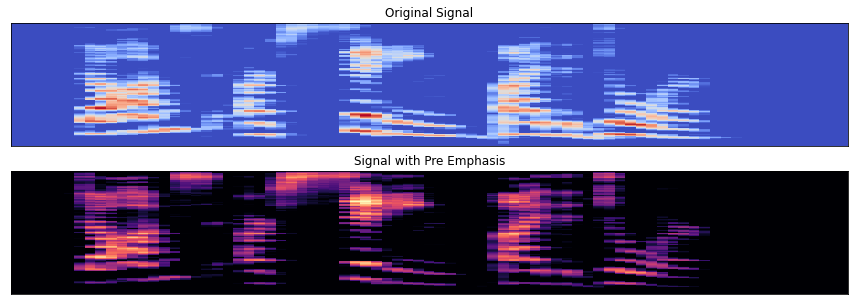

In [33]:
# 

# create variables for easy use 
emp = pre_emphasis(y)
emp_mel = librosa.feature.melspectrogram(emp)
emp_db = librosa.amplitude_to_db(emp_mel)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 5))
ax = ax.ravel()
# original signal 
librosa.display.specshow(mel_db, ax=ax[0])
ax[0].set(title='Original Signal')
ax[0].label_outer()
# shifted 
librosa.display.specshow(emp_db, ax=ax[1])
ax[1].set(title='Signal with Pre Emphasis')
ax[1].label_outer()
plt.savefig('/Users/stephen/Emotion_Detection-/images/pre_emph')

# Feature Extraction
one of the best ASR (automatic Speech Recognition) audio feature extract methods is using a combination of MFCC's, the delta of those MFCC's, and the delta of those deltas (AKA Delta-Deltas). Here we will create functions to extract the MFCC's from the mel spectrograms and from there extract those Delta's and then the Delta's of those Deltas. Delta's can be described as the trajectories of the MFCC coefficients over time

info on MFCC's can be found at the link below:
http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/

Other features extracted will be the RMS of the signal and Zero-Crossing. 

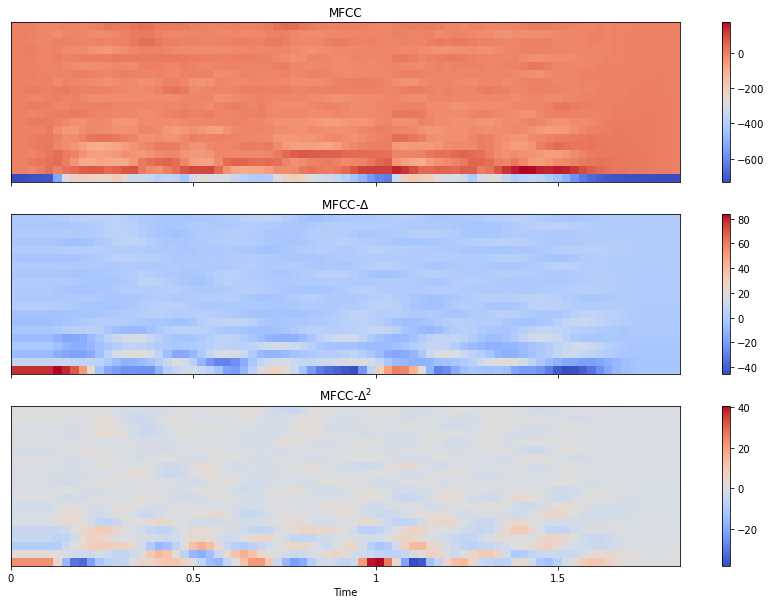

In [34]:
# Showing actual feature extractions used 
# resource: https://librosa.org/doc/main/generated/librosa.feature.delta.html?highlight=delta#librosa.feature.delta

test_mfcc = librosa.feature.mfcc(y=y, sr=sr)
test_mfcc_delta = librosa.feature.delta(test_mfcc)
test_mfcc_delta2 = librosa.feature.delta(test_mfcc, order=2)

fig, ax = plt.subplots(figsize=(15, 10), nrows=3, sharex=True, sharey=True)
img1 = librosa.display.specshow(test_mfcc, ax=ax[0], x_axis='time')
ax[0].set(title='MFCC')
ax[0].label_outer()
img2 = librosa.display.specshow(test_mfcc_delta, ax=ax[1], x_axis='time')
ax[1].set(title=r'MFCC-$\Delta$')
ax[1].label_outer()
img3 = librosa.display.specshow(test_mfcc_delta2, ax=ax[2], x_axis='time')
ax[2].set(title=r'MFCC-$\Delta^2$')
fig.colorbar(img1, ax=[ax[0]])
fig.colorbar(img2, ax=[ax[1]])
fig.colorbar(img3, ax=[ax[2]])
plt.savefig('/Users/stephen/Emotion_Detection-/images/MFCC')

# Baseline Model 

Here we will declare functions to prepare our data for a simple model. This model will only use the mel spectrogram as its feature input. Data augmentation will still use all the above functions.

In [35]:
def mel_features(path): 
    result = np.array([])
     
    mel = np.mean(librosa.feature.melspectrogram(y=path, sr=16000).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally    
    return result

def get_mel_features(path): 
    # duration and offset are used to take care of the no audio in start and the ending of each audio files .
    _data, sample_rate = librosa.load(path, sr=16000, duration=2.5, offset=0.8) 
    # apply High Pass filter to attenuate all signals below 80 hz
    sos = signal.butter(4, 80, 'hp', fs=1000, output='sos') # butterworth filter 
    data = signal.sosfilt(sos, _data)

    result = np.array([])
    # without augmentation
    res1 = mel_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = mel_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = mel_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    pre_emp_data = pre_emphasis(data)
    res4 = mel_features(pre_emp_data)
    result = np.vstack((result, res4)) # stacking vertically

    shift_data = shift(data)
    res5 = mel_features(shift_data)
    result = np.vstack((result, res5)) # stacking vertically 
    
    return result

we will iterate through the data and apply the feature extractions and data augmentation. X will contain the features and Y will have the labels

In [36]:
X, Y = [], []
for path, emotion in zip(Ravdess_df.Path, Ravdess_df.Emotions):
    feature = get_mel_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 4 times as we have made 4 augmentation techniques on each audio file.
        Y.append(emotion)

In [37]:
len(X), len(Y), Ravdess_df.Path.shape

(7200, 7200, (1440,))

In [38]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,labels
0,4.674843e-14,5.093816e-14,8.256547e-14,2.715827e-13,1.335198e-12,1.488450e-10,3.427490e-09,1.844458e-08,3.114518e-07,8.323994e-07,...,0.007071,0.011748,0.011426,0.010883,0.006832,0.004739,0.003541,0.000767,0.000079,angry
1,1.631931e-03,1.671173e-03,1.631134e-03,1.700206e-03,1.688303e-03,1.474591e-03,1.303942e-03,1.851133e-03,1.595618e-03,1.658025e-03,...,0.008829,0.013633,0.013009,0.012370,0.008433,0.006453,0.005063,0.002304,0.001867,angry
2,1.163589e-10,1.102588e-10,9.893140e-11,9.344531e-11,8.693234e-11,7.668718e-11,4.804653e-10,1.680575e-09,2.806575e-08,1.830156e-07,...,0.000762,0.000902,0.001543,0.002156,0.002025,0.001113,0.000623,0.000160,0.000005,angry
3,4.621531e-15,4.793744e-15,5.133564e-15,5.916328e-15,9.500880e-15,5.593221e-13,1.559318e-11,1.118584e-10,2.347093e-09,6.906392e-09,...,0.025747,0.043559,0.043036,0.041581,0.026425,0.018571,0.013968,0.003045,0.000315,angry
4,3.345760e-14,3.804370e-14,6.983877e-14,2.615246e-13,1.391183e-12,1.481214e-10,3.422153e-09,1.845552e-08,3.114030e-07,8.324891e-07,...,0.007071,0.011748,0.011426,0.010883,0.006832,0.004739,0.003541,0.000767,0.000079,angry


In [39]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [40]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [41]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5400, 128), (5400, 8), (1800, 128), (1800, 8))

In [43]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5400, 128), (5400, 8), (1800, 128), (1800, 8))

In [44]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5400, 128, 1), (5400, 8), (1800, 128, 1), (1800, 8))

# Baseline Model 
First for a simple model I won't use any data augmentation so no synthetic data will be used in this Convolutional Neural Network which I will also keep its architecture relatively simple so it can be compared to future models. 
The CNN will contain 3 layers of 1 dimensional CNN's, some MaxPooling and a couple of dropout layers. 

In [46]:
# Simple CNN Architecture. 


model_1=Sequential()
model_1.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model_1.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model_1.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model_1.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model_1.add(Dropout(0.2))

model_1.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model_1.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model_1.add(Dropout(0.3))

model_1.add(Flatten())
model_1.add(Dense(units=8, activation='softmax'))
model_1.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 128, 256)          1536      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 64, 256)          0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 64, 128)           163968    
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 32, 128)          0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 32, 128)           0         
                                                                 
 conv1d_5 (Conv1D)           (None, 32, 64)           

In [47]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history_1=model_1.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/100
85/85 [==============================] - 5s 55ms/step - loss: 1.9328 - accuracy: 0.2144 - val_loss: 1.8553 - val_accuracy: 0.2650 - lr: 0.0010
Epoch 2/100
85/85 [==============================] - 6s 70ms/step - loss: 1.8393 - accuracy: 0.2665 - val_loss: 1.7864 - val_accuracy: 0.2783 - lr: 0.0010
Epoch 3/100
85/85 [==============================] - 7s 78ms/step - loss: 1.8068 - accuracy: 0.2676 - val_loss: 1.7747 - val_accuracy: 0.2922 - lr: 0.0010
Epoch 4/100
85/85 [==============================] - 8s 90ms/step - loss: 1.7826 - accuracy: 0.2931 - val_loss: 1.7718 - val_accuracy: 0.3033 - lr: 0.0010
Epoch 5/100
85/85 [==============================] - 7s 86ms/step - loss: 1.7687 - accuracy: 0.2996 - val_loss: 1.7462 - val_accuracy: 0.2994 - lr: 0.0010
Epoch 6/100
85/85 [==============================] - 8s 90ms/step - loss: 1.7601 - accuracy: 0.3037 - val_loss: 1.7572 - val_accuracy: 0.3167 - lr: 0.0010
Epoch 7/100
85/85 [==============================] - 5s 54ms/step - lo

In [48]:
y_test.shape

(1800, 8)

57/57 [==============================] - 0s 7ms/step - loss: 1.4703 - accuracy: 0.4444
Accuracy of our model on test data :  44.44444477558136 %


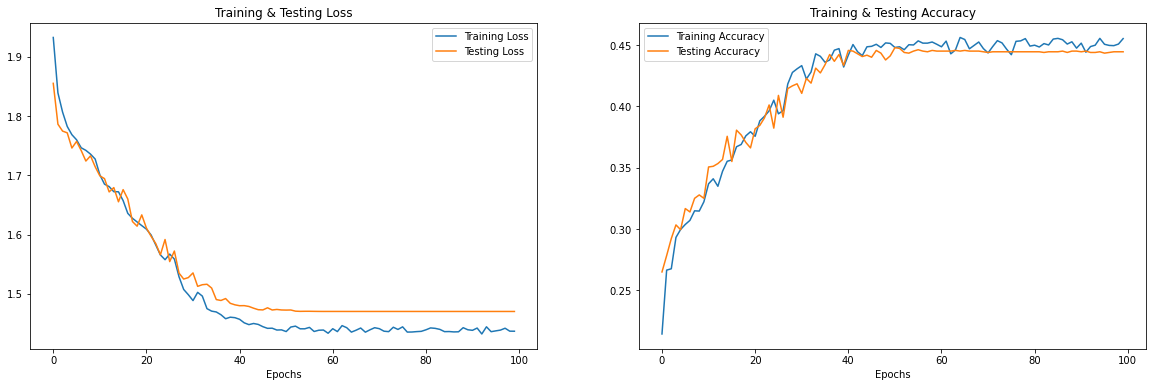

In [52]:
print("Accuracy of our model on test data : " , model_1.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = history_1.history['accuracy']
train_loss = history_1.history['loss']
test_acc = history_1.history['val_accuracy']
test_loss = history_1.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.savefig('/Users/stephen/Emotion_Detection-/images/Model1_Results', format='png')
plt.show()


# Model with more feature extractions 
Now for a model with all the data augmentations that where mentioned eearlier will be included. It's easier to delete the old variables from memory and rewrite some of the previous functions to include all the synthetic data. 

In [61]:
# Clear all global variables. Easier to start from scratch 

del X, Y, x_train, x_test, y_train, y_test, Features

Make new functions

In [62]:
def features(path): 
    sample_rate = 16000
    result = np.array([])
     
    mel = np.mean(librosa.feature.melspectrogram(y=path, sr=16000).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=mel, sr=sample_rate, n_mfcc=13).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # MFCC Delta
    mfcc_delta = np.mean(librosa.feature.delta(data=mfcc).T, axis=0)
    result = np.hstack((result, mfcc_delta)) # stacking horizontally

    # MFCC Delta-Delta
    mfcc_delta2 = np.mean(librosa.feature.delta(data=mfcc, order=2).T, axis=0)
    result = np.hstack((result, mfcc_delta2)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=mel).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally
    
    # Zero-crossing 
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=mel).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    return result

def get_features(path): 
    # duration and offset are used to take care of the no audio in start and the ending of each audio files .
    _data, sample_rate = librosa.load(path, sr=16000, duration=2.5, offset=0.8) 
    # apply High Pass filter to attenuate all signals below 80 hz
    sos = signal.butter(4, 80, 'hp', fs=1000, output='sos') # butterworth filter 
    data = signal.sosfilt(sos, _data)

    result = np.array([])
    # without augmentation
    res1 = features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    pre_emp_data = pre_emphasis(data)
    res4 = features(pre_emp_data)
    result = np.vstack((result, res4)) # stacking vertically

    shift_data = shift(data)
    res5 = features(shift_data)
    result = np.vstack((result, res5)) # stacking vertically 
    
    return result

In [63]:
X, Y = [], []
for path, emotion in zip(Ravdess_df.Path, Ravdess_df.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 4 times as we have made 4 augmentation techniques on each audio file.
        Y.append(emotion)

/Users/stephen/opt/anaconda3/envs/torch_env/lib/python3.9/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=128
  warnings.warn(


In [64]:
len(X), len(Y), Ravdess_df.Path.shape

(7200, 7200, (1440,))

In [65]:
Features = pd.DataFrame(X)
Features['labels'] = Y


X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5400, 145, 1), (5400, 8), (1800, 145, 1), (1800, 8))

# Second Model 
I will add MaxPooling and Dropouts layers as well as another 1 dimensional CNN


This architecture was taken from: https://www.kaggle.com/sslazio/speech-emotion-recognition-with-cnn 



Although the Neural Networks are the same the inputs are vastly different due to my different approach at dealing with the audio data in preprocessing 

In [66]:
# CNN 
model_2=Sequential()
# First CNN layer followed by MaxPooling
model_2.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model_2.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
# Second CNN layer followed by MaxPooling
model_2.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model_2.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
# Third CNN layer followed by MaxPooling and then Dropout 
model_2.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model_2.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model_2.add(Dropout(0.2))
# Fourth CNN layer followed by MaxPooling
model_2.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model_2.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
# Flatten layer followed by Dense and Dropout layers
model_2.add(Flatten())
model_2.add(Dense(units=32, activation='relu'))
model_2.add(Dropout(0.3))
# Second Flatten layer followed by Final Dense layer with output equal to number of classes
model_2.add(Flatten())
model_2.add(Dense(units=8, activation='softmax'))


# declaring Optimizer, Loss functions.
model_2.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 145, 256)          1536      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 73, 256)          0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 73, 256)           327936    
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 37, 256)          0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 37, 128)           163968    
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 19, 128)         

Since this model is mainly based of the Baseline Model It's only gona run for 50 Epochs just to see how the previous model holds up with new data augmentations. 

In [67]:

rlrp_2 = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history_2=model_2.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp_2])

Epoch 1/50
85/85 [==============================] - 8s 88ms/step - loss: 1.9838 - accuracy: 0.2146 - val_loss: 1.8945 - val_accuracy: 0.2600 - lr: 0.0010
Epoch 2/50
85/85 [==============================] - 8s 96ms/step - loss: 1.8848 - accuracy: 0.2643 - val_loss: 1.8254 - val_accuracy: 0.2933 - lr: 0.0010
Epoch 3/50
85/85 [==============================] - 9s 106ms/step - loss: 1.8349 - accuracy: 0.2713 - val_loss: 1.8083 - val_accuracy: 0.2922 - lr: 0.0010
Epoch 4/50
85/85 [==============================] - 8s 96ms/step - loss: 1.8062 - accuracy: 0.2883 - val_loss: 1.7652 - val_accuracy: 0.3056 - lr: 0.0010
Epoch 5/50
85/85 [==============================] - 8s 93ms/step - loss: 1.7882 - accuracy: 0.2954 - val_loss: 1.7431 - val_accuracy: 0.3128 - lr: 0.0010
Epoch 6/50
85/85 [==============================] - 8s 96ms/step - loss: 1.7594 - accuracy: 0.3006 - val_loss: 1.7433 - val_accuracy: 0.3156 - lr: 0.0010
Epoch 7/50
85/85 [==============================] - 8s 92ms/step - loss: 1.

57/57 [==============================] - 1s 11ms/step - loss: 1.4259 - accuracy: 0.6694
Accuracy of our model on test data :  66.94444417953491 %


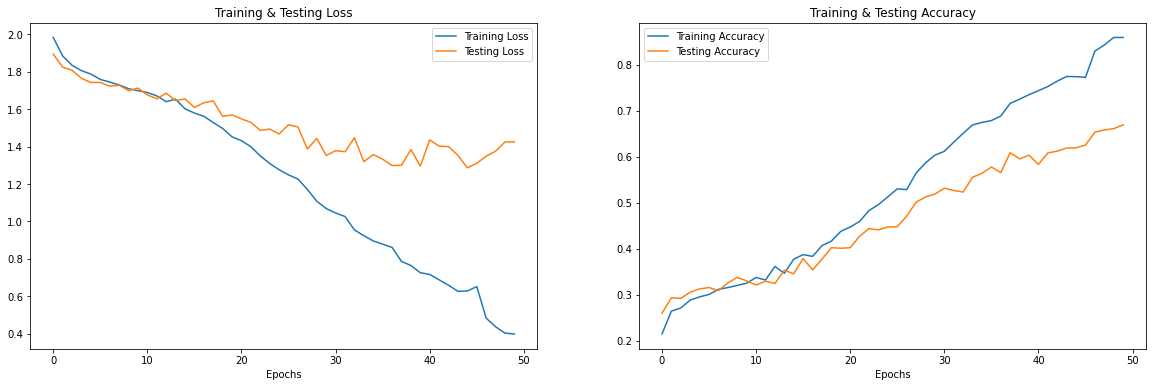

In [68]:
print("Accuracy of our model on test data : " , model_2.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history_2.history['accuracy']
train_loss = history_2.history['loss']
test_acc = history_2.history['val_accuracy']
test_loss = history_2.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.savefig('/Users/stephen/Emotion_Detection-/images/Model_2_Results')
plt.show()

Testing accuracy looks good but not so much the Loss functions. Seems to be some overfitting still going on 

# Model 3
 increase dropout layer and switched flatten layer to GlobalAveragePooling

In [69]:
model_3=Sequential()
# First CNN layer followed by MaxPooling
model_3.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model_3.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
# Second CNN layer followed by MaxPooling
model_3.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model_3.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
# Third CNN layer followed by MaxPooling then Dropout
model_3.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model_3.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model_3.add(Dropout(0.2))
# Fourth CNN layer followed by MaxPooling
model_3.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model_3.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
# First Dense layer followed by Dropout
model_3.add(Dense(units=32, activation='relu'))
model_3.add(Dropout(0.5))
# GlobalAveragePooling1D inplace of FLatten layer, followed by last Dense layer 
model_3.add(GlobalAveragePooling1D())
model_3.add(Dense(units=8, activation='softmax'))

model_3.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 145, 256)          1536      
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 73, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_11 (Conv1D)          (None, 73, 256)           327936    
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 37, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_12 (Conv1D)          (None, 37, 128)           163968    
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 19, 128)         

In [70]:
rlrp_3 = ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=0, patience=2, min_lr=0.0001)
history_3=model_3.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test), callbacks=[rlrp_3])

Epoch 1/100
85/85 [==============================] - 8s 90ms/step - loss: 1.9617 - accuracy: 0.2106 - val_loss: 1.8396 - val_accuracy: 0.2572 - lr: 0.0010
Epoch 2/100
85/85 [==============================] - 8s 94ms/step - loss: 1.8604 - accuracy: 0.2556 - val_loss: 1.7937 - val_accuracy: 0.2700 - lr: 0.0010
Epoch 3/100
85/85 [==============================] - 9s 102ms/step - loss: 1.8244 - accuracy: 0.2652 - val_loss: 1.7988 - val_accuracy: 0.2833 - lr: 0.0010
Epoch 4/100
85/85 [==============================] - 8s 97ms/step - loss: 1.8069 - accuracy: 0.2663 - val_loss: 1.7601 - val_accuracy: 0.2950 - lr: 0.0010
Epoch 5/100
85/85 [==============================] - 8s 91ms/step - loss: 1.7843 - accuracy: 0.2809 - val_loss: 1.7613 - val_accuracy: 0.2911 - lr: 0.0010
Epoch 6/100
85/85 [==============================] - 9s 102ms/step - loss: 1.7746 - accuracy: 0.2894 - val_loss: 1.7905 - val_accuracy: 0.2817 - lr: 0.0010
Epoch 7/100
85/85 [==============================] - 8s 99ms/step - 

57/57 [==============================] - 1s 11ms/step - loss: 1.3930 - accuracy: 0.5561
Accuracy of our model on test data :  55.61110973358154 %


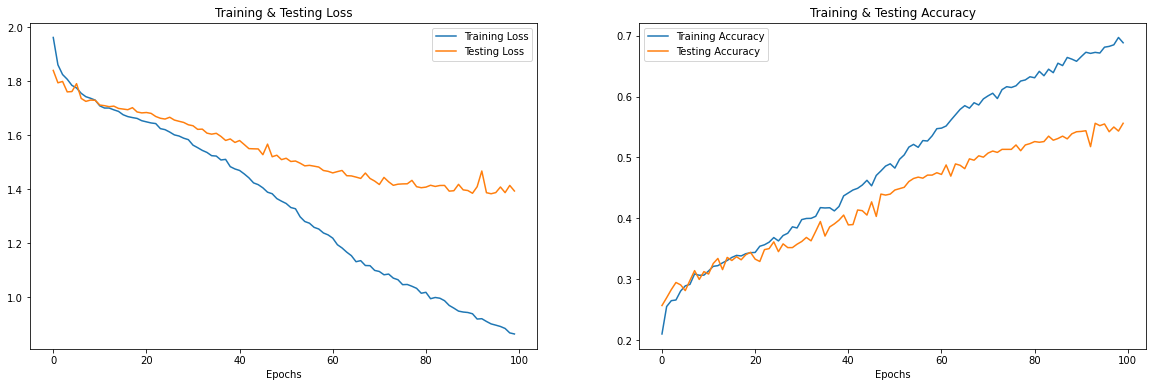

In [73]:
print("Accuracy of our model on test data : " , model_3.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = history_3.history['accuracy']
train_loss = history_3.history['loss']
test_acc = history_3.history['val_accuracy']
test_loss = history_3.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.savefig('/Users/stephen/Emotion_Detection-/images/Model_3_Results')
plt.show()

Lost some accuracy but atleast the Loss isnt as bad. On the right track

# Model 4
add L1 regulaziers and BatchNormalization

In [75]:
model_4=Sequential()

# First CNN layer followed by BatchNormalization then Maxpooling
model_4.add(Conv1D(16, kernel_size=5, strides=1, padding='same', activation='relu', kernel_regularizer=l1(0.01), input_shape=(x_train.shape[1], 1)))
model_4.add(BatchNormalization())
model_4.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

# Second CNN layer followed by BatchNormalization then Maxpooling and Dropout
model_4.add(Conv1D(32, kernel_size=5, strides=1, padding='same', activation='relu'))
model_4.add(BatchNormalization())
model_4.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model_4.add(Dropout(.1))

# Fourth CNN layer followed by BatchNormalization then Maxpooling
model_4.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model_4.add(BatchNormalization())
model_4.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

# Fourth CNN layer followed by MaxPooling, BatchNormalization then Dropout
model_4.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model_4.add(BatchNormalization())
model_4.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model_4.add(Dropout(0.25))
# GlobalAveragePooling1D inplace of FLatten layer, followed by last Dense layer 
model_4.add(GlobalAveragePooling1D())
# Dense layer follwed by Dropout and final Dense layer 
model_4.add(Dense(256, activation='relu'))
model_4.add(Dropout(0.5))
model_4.add(Dense(units=8, activation='softmax'))

model_4.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model_4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_14 (Conv1D)          (None, 145, 16)           96        
                                                                 
 batch_normalization (BatchN  (None, 145, 16)          64        
 ormalization)                                                   
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 73, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_15 (Conv1D)          (None, 73, 32)            2592      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 32)           128       
 hNormalization)                                                 
                                                      

In [76]:
rlrp_4 = ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=0, patience=2, min_lr=0.0001)
history_4=model_4.fit(x_train, y_train, batch_size=64, epochs=200, validation_data=(x_test, y_test), callbacks=[rlrp_4])

Epoch 1/200
85/85 [==============================] - 3s 25ms/step - loss: 2.0551 - accuracy: 0.2370 - val_loss: 2.1220 - val_accuracy: 0.1894 - lr: 0.0010
Epoch 2/200
85/85 [==============================] - 2s 20ms/step - loss: 1.9139 - accuracy: 0.2769 - val_loss: 2.1769 - val_accuracy: 0.1900 - lr: 0.0010
Epoch 3/200
85/85 [==============================] - 3s 36ms/step - loss: 1.8636 - accuracy: 0.2937 - val_loss: 2.3713 - val_accuracy: 0.1933 - lr: 0.0010
Epoch 4/200
85/85 [==============================] - 3s 34ms/step - loss: 1.8079 - accuracy: 0.3246 - val_loss: 2.3508 - val_accuracy: 0.1994 - lr: 4.0000e-04
Epoch 5/200
85/85 [==============================] - 2s 22ms/step - loss: 1.7839 - accuracy: 0.3309 - val_loss: 2.1017 - val_accuracy: 0.2144 - lr: 4.0000e-04
Epoch 6/200
85/85 [==============================] - 2s 19ms/step - loss: 1.7701 - accuracy: 0.3343 - val_loss: 1.9831 - val_accuracy: 0.2361 - lr: 4.0000e-04
Epoch 7/200
85/85 [==============================] - 2s 24

57/57 [==============================] - 0s 2ms/step - loss: 1.2504 - accuracy: 0.6767
Accuracy of our model on test data :  67.66666769981384 %


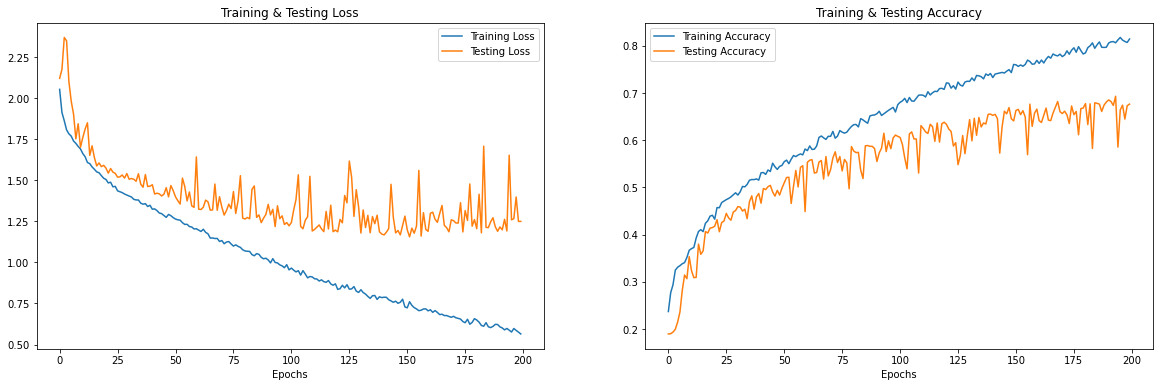

In [77]:
print("Accuracy of our model on test data : " , model_4.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(200)]
fig , ax = plt.subplots(1,2)
train_acc = history_4.history['accuracy']
train_loss = history_4.history['loss']
test_acc = history_4.history['val_accuracy']
test_loss = history_4.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.savefig('/Users/stephen/Emotion_Detection-/images/Model_4_Results')
plt.show()

# Final Model 
The last model is looking pretty good so lets try a few more things. lets try adding more dropouts and switch to L2 Regularization

In [78]:
final_model=Sequential()

final_model.add(Conv1D(16, kernel_size=5, strides=1, padding='same', activation='relu', kernel_regularizer=l2(0.01), input_shape=(x_train.shape[1], 1)))
final_model.add(BatchNormalization())
final_model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
final_model.add(Dropout(0.05))

final_model.add(Conv1D(32, kernel_size=5, strides=1, padding='same', activation='relu'))
final_model.add(BatchNormalization())
final_model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
final_model.add(Dropout(.10))

final_model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
final_model.add(BatchNormalization())
final_model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
final_model.add(Dropout(.20))

final_model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
final_model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
final_model.add(BatchNormalization())
final_model.add(Dropout(0.25))

final_model.add(GlobalAveragePooling1D())

final_model.add(Dense(256, activation='relu'))
final_model.add(Dropout(0.50))

final_model.add(Dense(units=8, activation='softmax'))
final_model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])


final_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 145, 16)           96        
                                                                 
 batch_normalization_4 (Batc  (None, 145, 16)          64        
 hNormalization)                                                 
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 73, 16)           0         
 g1D)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 73, 16)            0         
                                                                 
 conv1d_19 (Conv1D)          (None, 73, 32)            2592      
                                                                 
 batch_normalization_5 (Batc  (None, 73, 32)          

In [79]:
rlrp_final = ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=0, patience=2, min_lr=0.0001)
history_final=final_model.fit(x_train, y_train, batch_size=64, epochs=1000, validation_data=(x_test, y_test), callbacks=[rlrp_final])

Epoch 1/1000
85/85 [==============================] - 6s 26ms/step - loss: 1.9364 - accuracy: 0.2435 - val_loss: 2.1138 - val_accuracy: 0.1633 - lr: 0.0010
Epoch 2/1000
85/85 [==============================] - 2s 21ms/step - loss: 1.8543 - accuracy: 0.2694 - val_loss: 2.1706 - val_accuracy: 0.1967 - lr: 0.0010
Epoch 3/1000
85/85 [==============================] - 2s 22ms/step - loss: 1.8055 - accuracy: 0.2869 - val_loss: 2.2552 - val_accuracy: 0.1633 - lr: 0.0010
Epoch 4/1000
85/85 [==============================] - 2s 21ms/step - loss: 1.7812 - accuracy: 0.3041 - val_loss: 2.1051 - val_accuracy: 0.1639 - lr: 4.0000e-04
Epoch 5/1000
85/85 [==============================] - 2s 21ms/step - loss: 1.7664 - accuracy: 0.3022 - val_loss: 1.9462 - val_accuracy: 0.2133 - lr: 4.0000e-04
Epoch 6/1000
85/85 [==============================] - 2s 21ms/step - loss: 1.7608 - accuracy: 0.3093 - val_loss: 1.8859 - val_accuracy: 0.2317 - lr: 4.0000e-04
Epoch 7/1000
85/85 [==============================] 

57/57 [==============================] - 0s 3ms/step - loss: 0.9893 - accuracy: 0.7011
Accuracy of our model on test data :  70.11111378669739 %


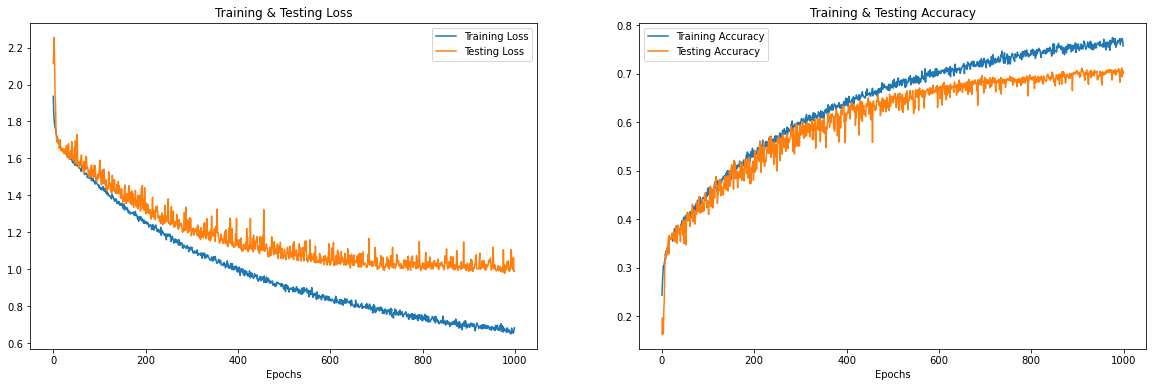

In [80]:
print("Accuracy of our model on test data : " , final_model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(1000)]
fig , ax = plt.subplots(1,2)
train_acc = history_final.history['accuracy']
train_loss = history_final.history['loss']
test_acc = history_final.history['val_accuracy']
test_loss = history_final.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.savefig('/Users/stephen/Emotion_Detection-/images/Final_Model_Results')
plt.show()

# Evaluation 
70% accuracy for a multiclassification problem is considered pretty good and at this point I think the model is performing well enough. Lets take a lot at some more results

In [81]:
# predicting on test data.
pred_test = final_model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [82]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,sad,disgust
1,surprise,disgust
2,sad,sad
3,happy,happy
4,angry,angry
5,fear,disgust
6,fear,fear
7,disgust,disgust
8,disgust,fear
9,fear,fear


Lets see how well the model had with accuracy across all the different classes with a confusion matrix 

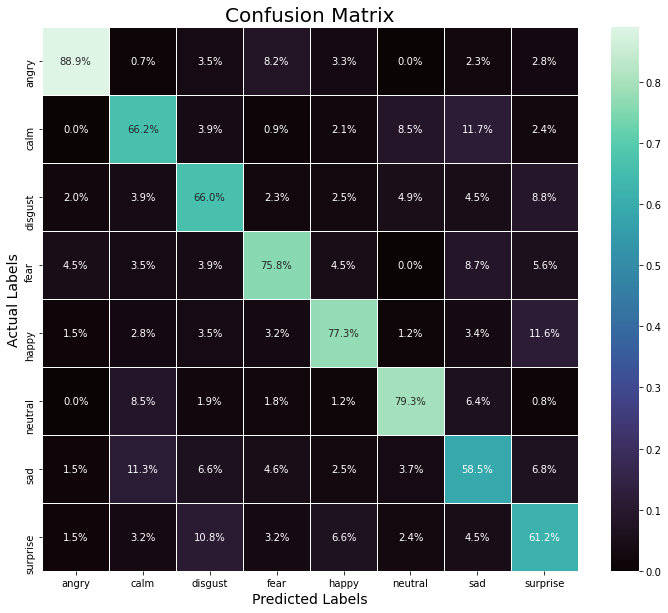

In [83]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm/ np.sum(cm), linecolor='white', cmap='mako', linewidth=1, annot=True, fmt='.1%')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('/Users/stephen/Emotion_Detection-/images/Confussion_matrix')
plt.show()

In [85]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.89      0.78      0.83       227
        calm       0.66      0.76      0.71       249
     disgust       0.66      0.73      0.69       235
        fear       0.76      0.68      0.72       243
       happy       0.77      0.74      0.76       253
     neutral       0.79      0.54      0.64       120
         sad       0.58      0.64      0.61       243
    surprise       0.61      0.67      0.64       230

    accuracy                           0.70      1800
   macro avg       0.72      0.69      0.70      1800
weighted avg       0.71      0.70      0.70      1800



# Conclusion 

Next I would like to add more data as there are a few more less known datasets for emotion detection, I do have a few more ideas on how to clean the audio. A popular research topic on this problem is that these types of models tend to confuse male and female voices and it can throw off the results so i would like to see what happens when I put them into there own models and it there is a difference I would attempt to solve it with introducing my “audio Engineering” features like more equalization and compression to more normalize the data and to stop the model from getting confused. 


# Sources 
Ideas and architecture in this model where influenced and inspired by the following projects: 

Shivam Burnwal:  https://www.kaggle.com/shivamburnwal/speech-emotion-recognition
Valerio Velardo: https://github.com/musikalkemist/pytorchforaudio
Nickolas Indorf, Andrew Whitman and myself: https://github.com/Jyve00/MIR
Jeremy Pagirsky: https://github.com/jeremypagirsky/birdcall_classification/blob/main/birdclef-audio-classification.ipynb